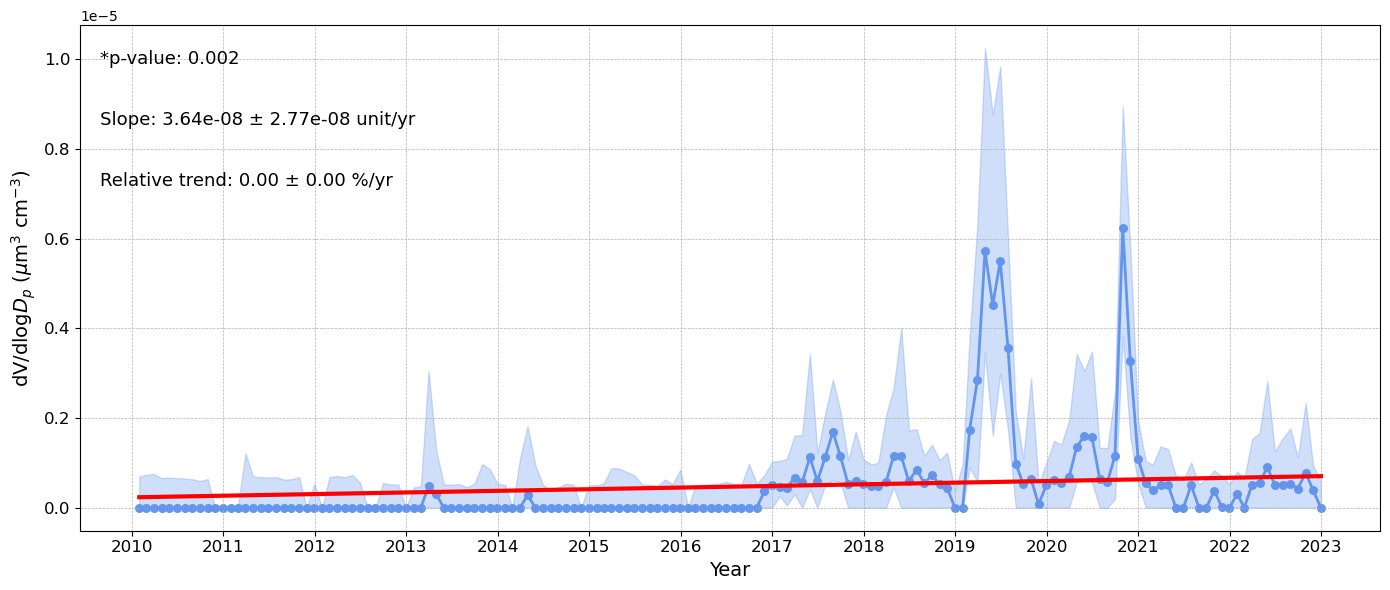

In [1]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== File Path ====
file_path = '/Users/touqeergill/Desktop/10. Volume_Distribution_dV_dlogDp.xlsx'

# ==== Helper Functions ====

def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def custom_func(x, quantile):
    len_month = days_in_month(x.index)
    return x.quantile(quantile) if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    x = pd.Series(x).dropna()
    n = len(x)
    acfs = acf(x, nlags=nlags, fft=True)[1:]
    ess = n / (1 + 2 * np.sum(acfs))
    return max(ess, 1)

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

# ==== Plot Function ====
def plot_trend_with_yticks(x, y, y_low, y_up, ylabel):
    fig, ax = plt.subplots(figsize=(14, 6))

    x_num = (pd.to_datetime(x) - pd.to_datetime(x[0])) / np.timedelta64(1, 'D')

    tau, p_value = modified_mk_test(x_num, y)
    slope, intercept, slope_lo, slope_hi = theilslopes(y, x_num, alpha=0.95)
    slope_unc = (slope_hi - slope_lo) / 2
    median_y = np.median(y)
    slope_yr = slope * 365.25
    slope_unc_yr = slope_unc * 365.25
    rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
    rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

    slope_txt = f"Slope: {slope_yr:.2e} ± {slope_unc_yr:.2e} unit/yr"
    rel_txt = f"Relative trend: {rel_trend:.2f} ± {rel_unc:.2f} %/yr"
    p_txt = f"{'*' if p_value <= 0.05 else ''}p-value: {p_value:.3f}"

    ax.scatter(x, y, s=30, color='cornflowerblue')
    ax.fill_between(x, y_low, y_up, color='cornflowerblue', alpha=0.3)
    ax.plot(x, y, linestyle='-', color='cornflowerblue', linewidth=2)

    trend_y = slope * (x_num - np.mean(x_num)) + np.mean(y)
    ax.plot(x, trend_y, 'red', linestyle='-' if p_value <= 0.05 else '--', linewidth=3)

    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='both', labelsize=12)

    ax.text(0.015, 0.95, p_txt, transform=ax.transAxes, fontsize=13, va='top')
    ax.text(0.015, 0.83, slope_txt, transform=ax.transAxes, fontsize=13, va='top')
    ax.text(0.015, 0.71, rel_txt, transform=ax.transAxes, fontsize=13, va='top')

    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# ==== Load and Process Data ====
df = pd.read_excel(file_path, sheet_name='Sheet1')
df.columns.values[0] = 'datetime'
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Select one size bin (first column)
size_bin = df.columns[0]
df_bin = df[[size_bin]].copy()

# Resample to monthly
resampled = df_bin.resample('M').agg([
    custom_median,
    lambda x: custom_func(x, 0.25),
    lambda x: custom_func(x, 0.75)
])

# Clean and extract
y_main = pd.to_numeric(resampled[(size_bin, 'custom_median')], errors='coerce')
y_low = pd.to_numeric(resampled[(size_bin, '<lambda_0>')], errors='coerce')
y_up = pd.to_numeric(resampled[(size_bin, '<lambda_1>')], errors='coerce')

mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
x_vals = resampled.index[mask].to_numpy()
y_vals = y_main[mask].to_numpy(dtype='float64')
y_low_vals = y_low[mask].to_numpy(dtype='float64')
y_up_vals = y_up[mask].to_numpy(dtype='float64')

# ==== Final Plot ====
plot_trend_with_yticks(
    x=x_vals,
    y=y_vals,
    y_low=y_low_vals,
    y_up=y_up_vals,
    ylabel=r"dV/dlog$D_p$ ($\mu$m$^3$ cm$^{-3}$)"
)

/var/folders/4t/47wt24490m52zgk23b06kc9m0000gn/T/ipykernel_51415/4276407184.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust bottom margin for horizontal legend


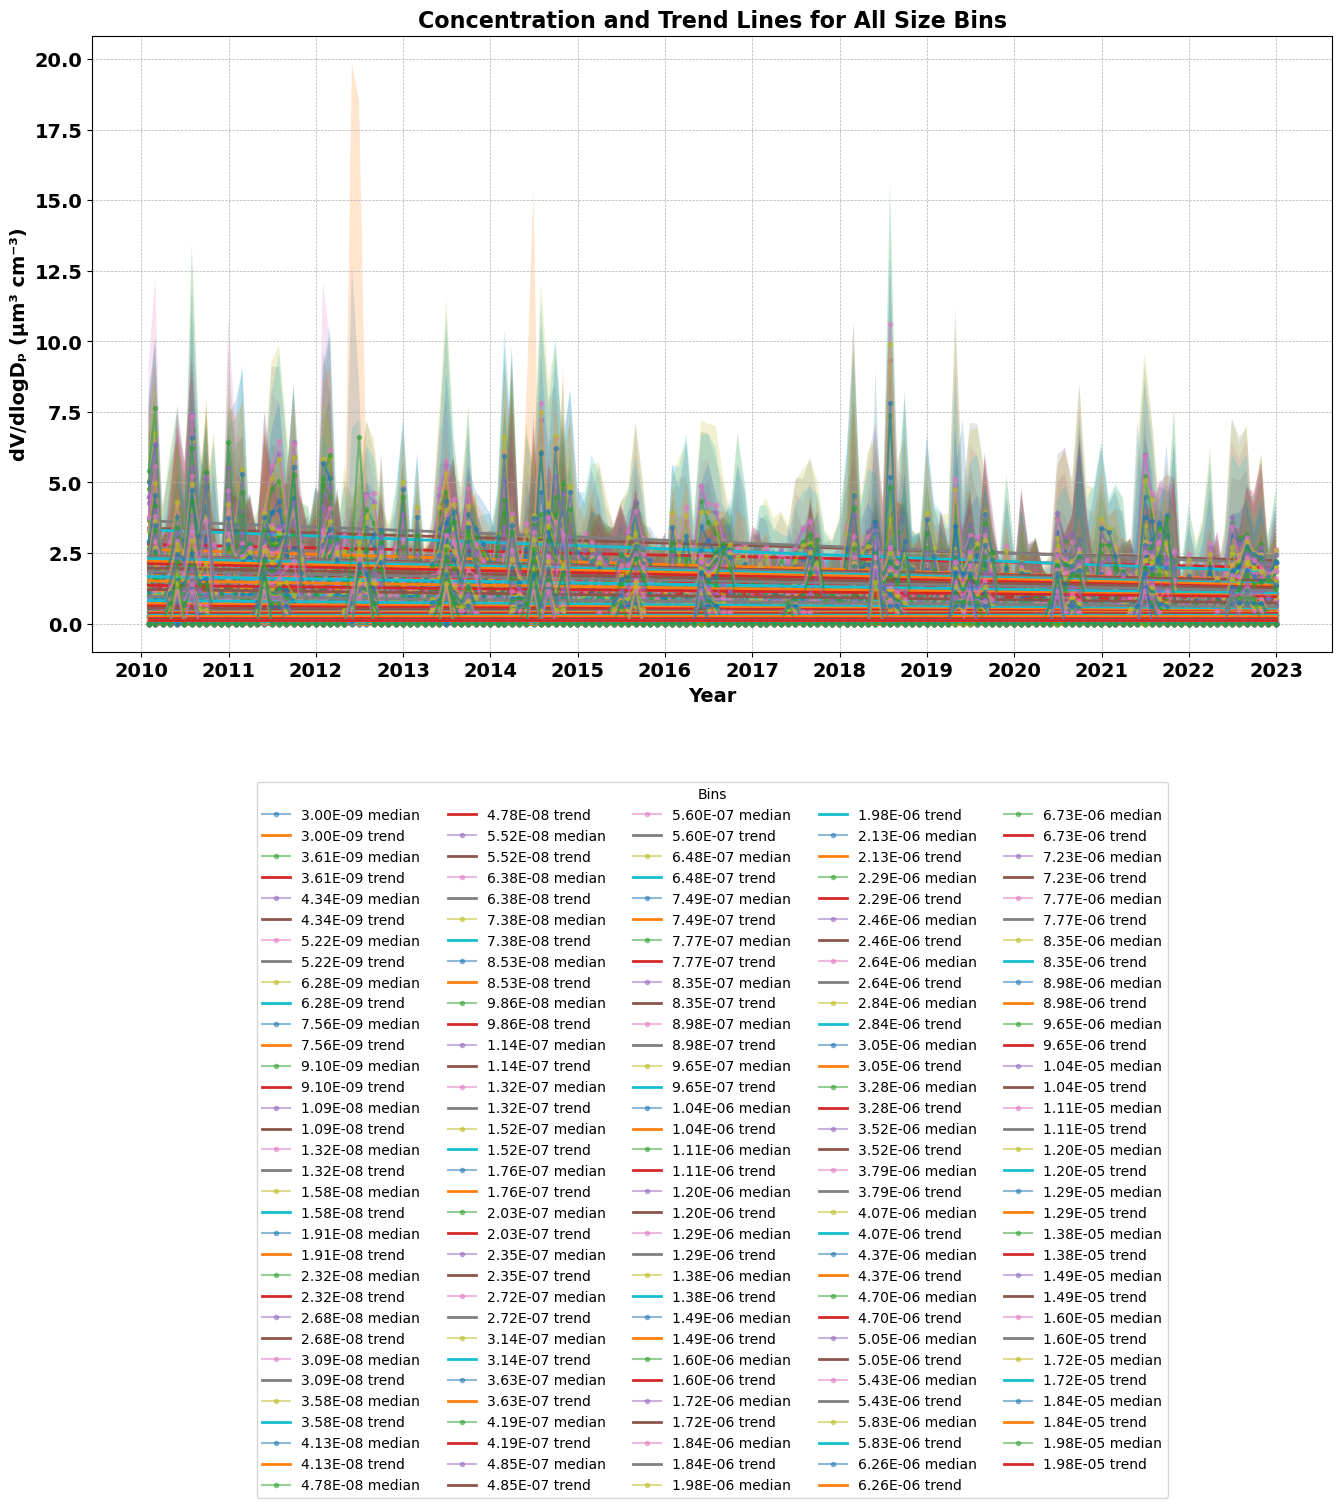

Trend statistics (µm³/cm³) saved to: /Users/touqeergill/Desktop/Volume_Distribution_dV_dlogDp.xlsx


In [2]:
# ==== Import Packages ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import kendalltau, theilslopes, norm
from statsmodels.tsa.stattools import acf

# ==== Helper Functions ====

def days_in_month(date):
    if len(date) > 0:
        next_month = date[0].replace(day=28) + pd.Timedelta(days=4)
        return (next_month - pd.Timedelta(days=next_month.day)).day
    return 0

def custom_median(x):
    len_month = days_in_month(x.index)
    return x.median() if len(x) >= 0.75 * len_month else np.nan

def effective_sample_size(x, nlags=12):
    x = pd.Series(x).dropna()
    n = len(x)
    acfs = acf(x, nlags=nlags, fft=True)[1:]
    ess = n / (1 + 2 * np.sum(acfs))
    return max(ess, 1)

def modified_mk_test(x, y):
    tau, _ = kendalltau(x, y)
    n_eff = effective_sample_size(y)
    z = tau * np.sqrt((9 * n_eff * (n_eff - 1)) / (2 * (2 * n_eff + 5)))
    p = 2 * (1 - norm.cdf(abs(z)))
    return tau, p

# ==== Load and Process Data ====
file_path = '/Users/touqeergill/Desktop/10. Volume_Distribution_dV_dlogDp.xlsx'
df = pd.read_excel(file_path)
df.columns.values[0] = 'datetime'
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# ==== Resampling ====
resampled = df.resample('M').agg(custom_median)

# ==== Plot All 10 Bins with Trend Lines ====
fig, ax = plt.subplots(figsize=(16, 8))
x_dates = resampled.index
x_num = (x_dates - x_dates[0]) / np.timedelta64(1, 'D')
x_num = x_num.to_numpy()

for col in resampled.columns:
    y_main = resampled[col]
    y_low = df[[col]].resample('M').quantile(0.25)[col]
    y_up = df[[col]].resample('M').quantile(0.75)[col]

    mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
    if np.sum(mask) < 12:
        continue

    x_vals = x_dates[mask]
    y_vals = y_main[mask].to_numpy(dtype='float64')
    y_low_vals = y_low[mask].to_numpy(dtype='float64')
    y_up_vals = y_up[mask].to_numpy(dtype='float64')
    x_num_masked = x_num[mask]

    # Plot concentration
    ax.plot(x_vals, y_vals, linewidth=1.5, marker='o', markersize=3, alpha=0.5, label=f"{col} median")
    ax.fill_between(x_vals, y_low_vals, y_up_vals, alpha=0.2)

    # Plot trend line
    slope, intercept, _, _ = theilslopes(y_vals, x_num_masked, alpha=0.95)
    trend_y = slope * (x_num_masked - np.mean(x_num_masked)) + np.mean(y_vals)
    ax.plot(x_vals, trend_y, linestyle='-', linewidth=2, label=f"{col} trend")

# Formatting
ax.set_title("Concentration and Trend Lines for All Size Bins", fontsize=16, fontweight='bold')
ax.set_xlabel("Year", fontsize=14, fontweight='bold')
ax.set_ylabel('dV/dlogDₚ (µm³ cm⁻³)', fontsize=14, fontweight='bold')
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='both', labelsize=14)

# Make tick labels bold
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# Horizontal legend below the plot
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.2),
          ncol=5,  # Adjust columns based on number of bins
          fontsize=10,
          title="Bins")

plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Adjust bottom margin for horizontal legend
plt.show()

# ==== Compute Trend Statistics Table ====
trend_stats = []

for col in resampled.columns:
    y_main = resampled[col]
    y_low = df[[col]].resample('M').quantile(0.25)[col]
    y_up = df[[col]].resample('M').quantile(0.75)[col]

    mask = (~y_main.isna()) & (~y_low.isna()) & (~y_up.isna())
    if np.sum(mask) < 12:
        continue

    x_vals = x_dates[mask]
    y_vals = y_main[mask].to_numpy(dtype='float64')
    x_num_masked = x_num[mask]

    try:
        tau, p_value = modified_mk_test(x_num_masked, y_vals)
        slope, intercept, slope_lo, slope_hi = theilslopes(y_vals, x_num_masked, alpha=0.95)
        slope_unc = (slope_hi - slope_lo) / 2
        median_y = np.median(y_vals)
        slope_yr = slope * 365.25
        slope_unc_yr = slope_unc * 365.25
        rel_trend = (slope_yr / abs(median_y)) * 100 if median_y != 0 else 0
        rel_unc = (slope_unc_yr / abs(median_y)) * 100 if median_y != 0 else 0

        trend_stats.append({
            'Bin': col,
            'Slope (unit/yr)': slope_yr,
            '± Slope Uncertainty': slope_unc_yr,
            'Relative Trend (%/yr)': rel_trend,
            '± Relative Uncertainty': rel_unc,
            'p-value': p_value
        })
    except Exception:
        continue

trend_df = pd.DataFrame(trend_stats)

# ==== Save Trend Statistics to Excel ====
output_path = '/Users/touqeergill/Desktop/Volume_Distribution_dV_dlogDp.xlsx'
trend_df.to_excel(output_path, index=False)

print(f"Trend statistics (µm³/cm³) saved to: {output_path}")

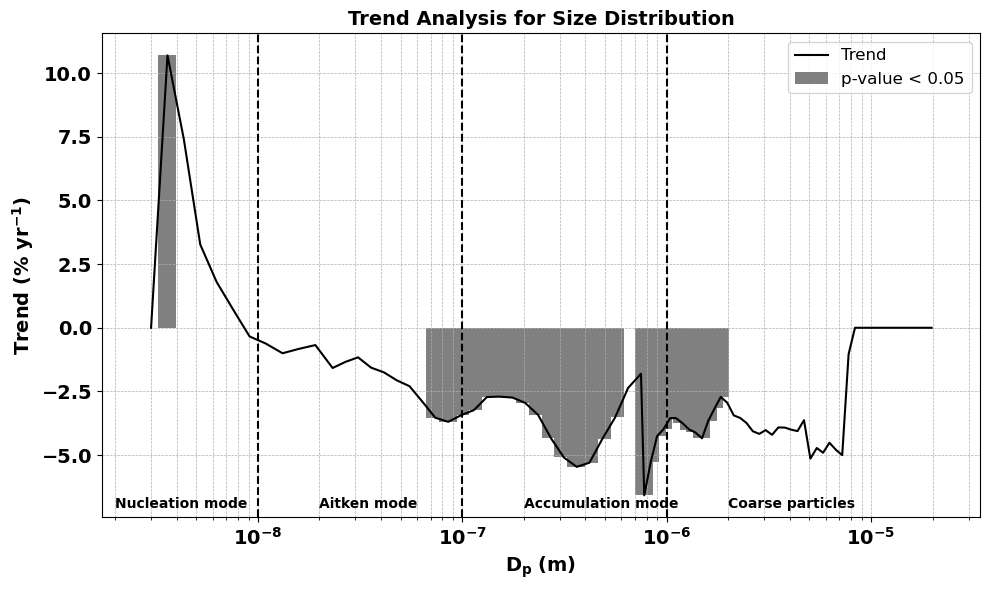

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file from the uploaded version
file_path = '/Users/touqeergill/Desktop/10. Volume Distribution (P value).xlsx'
df = pd.read_excel(file_path)

# Extract relevant data
particle_sizes = df['Bin'].astype(float).to_numpy()
trends = df['Relative Trend (%/yr)'].to_numpy()
p_values = df['p-value'].to_numpy()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the trend line
ax.plot(particle_sizes, trends, color='black', label='Trend')

# Highlight statistically significant bins (p < 0.05)
significant = p_values < 0.05
ax.bar(particle_sizes[significant], trends[significant],
       width=particle_sizes[significant] * 0.2, color='gray', label='p-value < 0.05')

# Mark vertical lines for mode boundaries
mode_boundaries = [1e-8, 1e-7, 1e-6]
for boundary in mode_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--')

# Adjust Y position for annotations
label_y_position = min(trends) - 0.5
ax.text(2e-9, label_y_position, 'Nucleation mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-8, label_y_position, 'Aitken mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-7, label_y_position, 'Accumulation mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-6, label_y_position, 'Coarse particles', fontsize=10, fontweight='bold', ha='left')

# Axis formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=14)
ax.set_ylabel(r'Trend (% yr$^{\mathbf{-1}}$)', fontsize=14, fontweight='bold')
ax.set_title('Trend Analysis for Size Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Make x and y ticks bold with font size 14
ax.tick_params(axis='both', labelsize=14)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

plt.tight_layout()
plt.show()

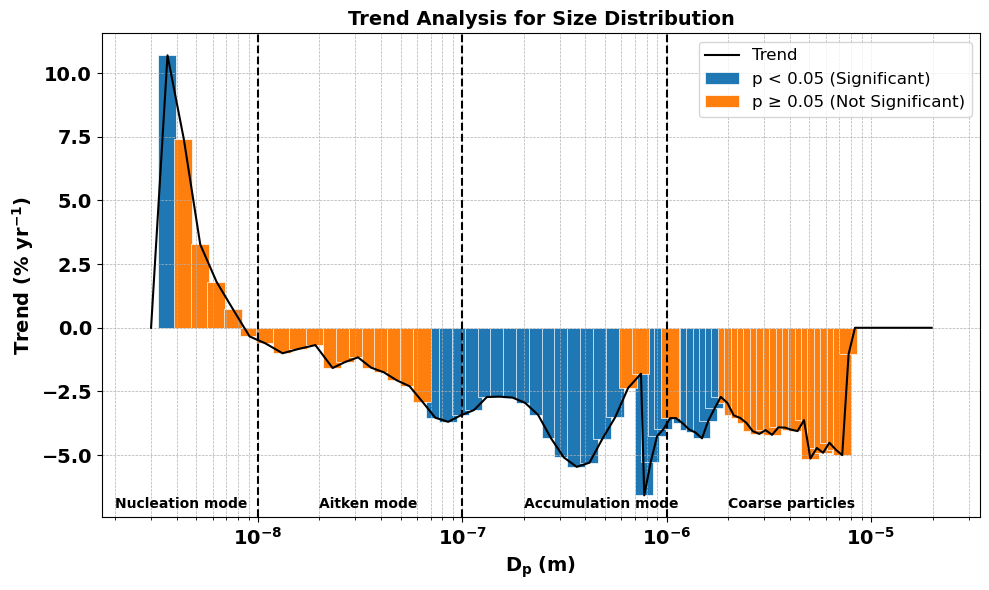

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/Users/touqeergill/Desktop/10. Volume Distribution (P value).xlsx'  # Adjust path as needed
df = pd.read_excel(file_path)

# Extract relevant data
particle_sizes = df['Bin'].astype(float).to_numpy()
trends = df['Relative Trend (%/yr)'].to_numpy()
p_values = df['p-value'].to_numpy()

# Define significance categories
significant = p_values < 0.05
not_significant = p_values >= 0.05

# Set y-position for mode labels just below the lowest trend value
label_y_position = min(trends) - 0.5

# Define custom colors
color_significant = '#1f77b4'  # muted blue
color_not_significant = '#ff7f0e'  # soft orange

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot trend line
ax.plot(particle_sizes, trends, color='black', label='Trend')

# Plot bars with white outlines
ax.bar(particle_sizes[significant], trends[significant],
       width=particle_sizes[significant] * 0.2, color=color_significant,
       edgecolor='white', linewidth=0.5, label='p < 0.05 (Significant)')
ax.bar(particle_sizes[not_significant], trends[not_significant],
       width=particle_sizes[not_significant] * 0.2, color=color_not_significant,
       edgecolor='white', linewidth=0.5, label='p ≥ 0.05 (Not Significant)')

# Add vertical lines for particle mode boundaries
mode_boundaries = [1e-8, 1e-7, 1e-6]
for boundary in mode_boundaries:
    ax.axvline(x=boundary, color='black', linestyle='--')

# Add mode annotations
ax.text(2e-9, label_y_position, 'Nucleation mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-8, label_y_position, 'Aitken mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-7, label_y_position, 'Accumulation mode', fontsize=10, fontweight='bold', ha='left')
ax.text(2e-6, label_y_position, 'Coarse particles', fontsize=10, fontweight='bold', ha='left')

# Axis formatting
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=14)
ax.set_ylabel(r'Trend (% yr$^{\mathbf{-1}}$)', fontsize=14, fontweight='bold')
ax.set_title('Trend Analysis for Size Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Bold x and y tick labels
ax.tick_params(axis='both', labelsize=14)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')

# Final layout
plt.tight_layout()
plt.show()

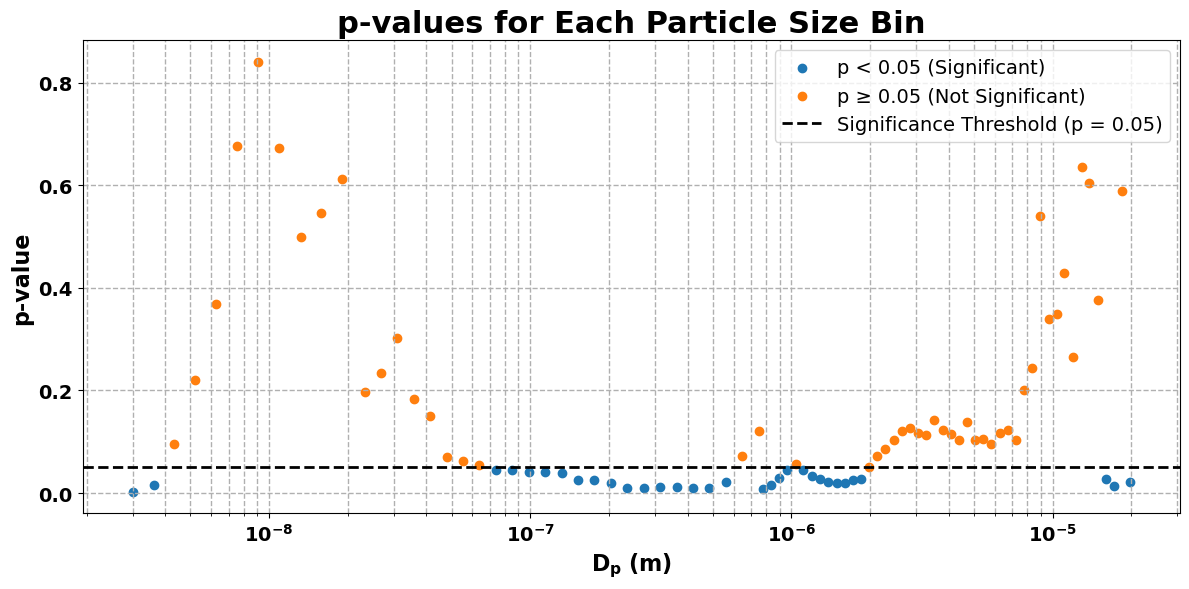

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = '/Users/touqeergill/Desktop/10. Volume Distribution (P value).xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the relevant sheet (assumes p-values are in Sheet1)
sheet1_df = excel_data.parse('Sheet1')

# Extract data
bins = sheet1_df['Bin']
p_values = sheet1_df['p-value']

# Separate for custom legends
significant = sheet1_df[p_values < 0.05]
not_significant = sheet1_df[p_values >= 0.05]

# Define custom colors
color_significant = '#1f77b4'  # muted blue
color_not_significant = '#ff7f0e'  # soft orange

# Create the plot
plt.figure(figsize=(12, 6))
plt.scatter(significant['Bin'], significant['p-value'], color=color_significant, label='p < 0.05 (Significant)')
plt.scatter(not_significant['Bin'], not_significant['p-value'], color=color_not_significant, label='p ≥ 0.05 (Not Significant)')

# Add thicker horizontal line at p = 0.05
plt.axhline(y=0.05, color='black', linestyle='--', linewidth=2, label='Significance Threshold (p = 0.05)')

# Set log scale for x-axis
plt.xscale('log')

# Bold labels and title with font size
plt.xlabel(r'$\mathbf{D}_{\mathbf{p}}$ $\mathbf{(m)}$', fontsize=16)
plt.ylabel('p-value', fontweight='bold', fontsize=16)
plt.title('p-values for Each Particle Size Bin', fontweight='bold', fontsize=22)

# Bold and size 14 for tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')

# Legend with bold font and size
plt.legend(fontsize=14)
plt.grid(True, which="both", ls="--", linewidth=1)
plt.tight_layout()

# Show plot
plt.show()

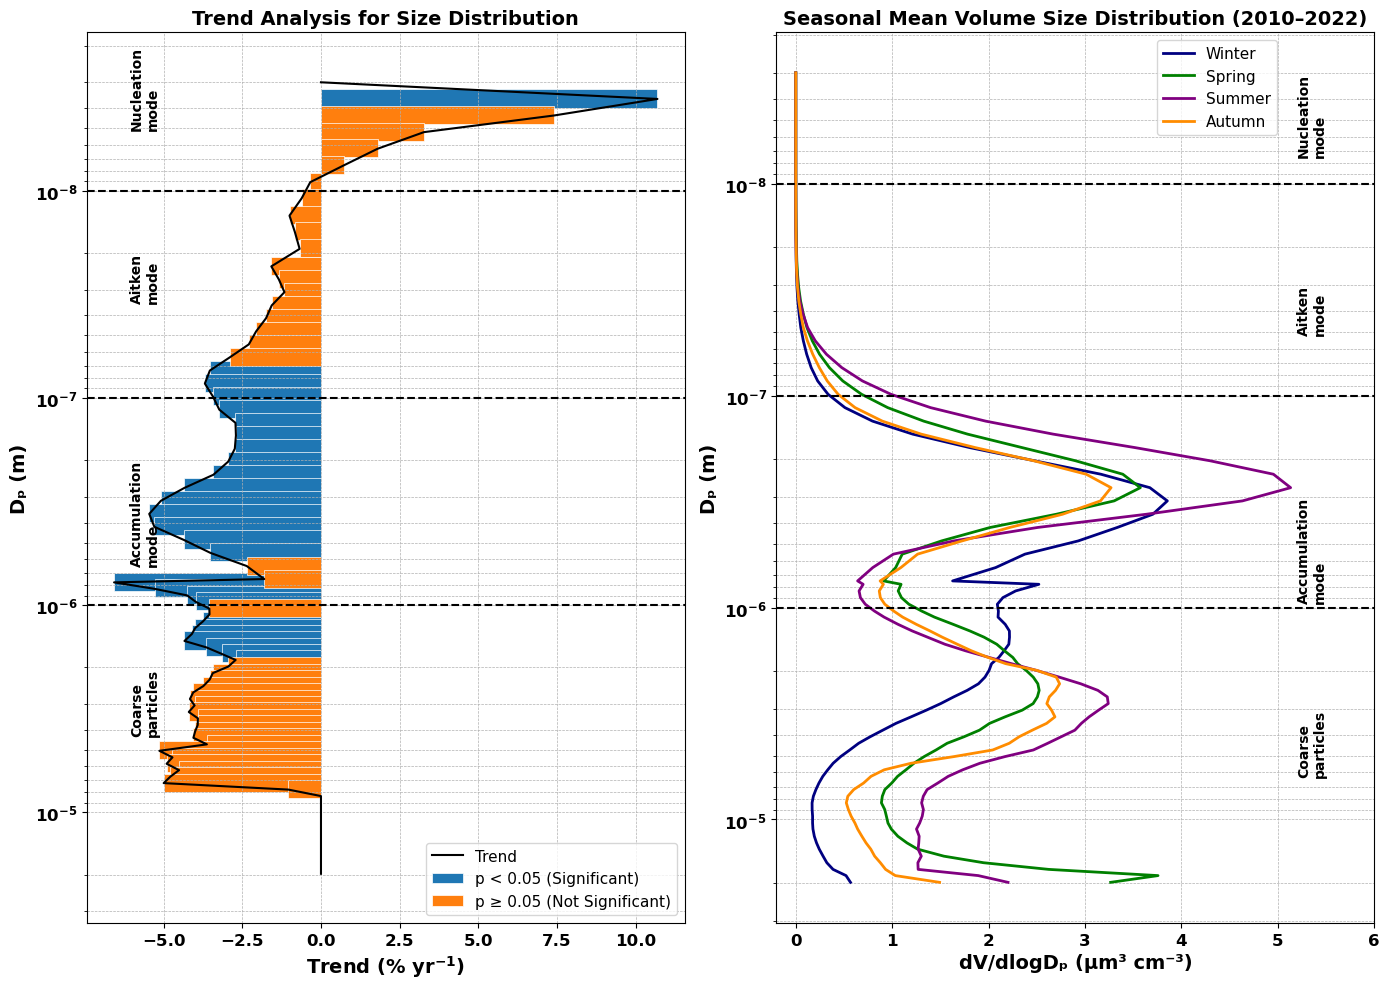

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths === #
file_path_1 = '/Users/touqeergill/Desktop/10. DMPS + APS Hourly Avg (2010-2022).xlsx'
file_path_2 = '/Users/touqeergill/Desktop/10. Volume Distribution (P value).xlsx'

# === Load and prepare first dataset === #
df1 = pd.read_excel(file_path_1)
df1['datetime'] = pd.to_datetime(df1['datetime'])

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

df1['Season'] = df1['datetime'].dt.month.apply(get_season)
diameter_cols = df1.columns[1:-1]
diameters_m = np.array([float(col) for col in diameter_cols])
diameters_um = diameters_m * 1e6
volume_factors = (np.pi / 6) * diameters_um**3
volume_df = df1[diameter_cols] * volume_factors
volume_df['Season'] = df1['Season']
seasonal_means = volume_df.groupby('Season').mean()

# === Load and prepare second dataset === #
df2 = pd.read_excel(file_path_2)
particle_sizes = df2['Bin'].astype(float).to_numpy()
trends = df2['Relative Trend (%/yr)'].to_numpy()
p_values = df2['p-value'].to_numpy()
significant = p_values < 0.05
not_significant = p_values >= 0.05

# === Adjusted label positions === #
label_x_position_trend = min(trends) + 0.5    # Slightly inside from left
label_x_position_volume = 5.2                 # Slightly inside from right

# === Define colors === #
colors = {'Winter': 'navy', 'Spring': 'green', 'Summer': 'purple', 'Autumn': 'darkorange'}

# === Create the figure === #
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# --- Plot 1: Trend Analysis --- #
ax1 = axs[0]
ax1.plot(trends, particle_sizes, color='black', label='Trend')
ax1.barh(particle_sizes[significant], trends[significant],
         height=particle_sizes[significant] * 0.2, color='#1f77b4',
         edgecolor='white', linewidth=0.5, label='p < 0.05 (Significant)')
ax1.barh(particle_sizes[not_significant], trends[not_significant],
         height=particle_sizes[not_significant] * 0.2, color='#ff7f0e',
         edgecolor='white', linewidth=0.5, label='p ≥ 0.05 (Not Significant)')

for boundary in [1e-8, 1e-7, 1e-6]:
    ax1.axhline(y=boundary, color='black', linestyle='--')

# Mode labels (slightly right of y-axis)
ax1.text(label_x_position_trend, 2e-9, 'Nucleation\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_position_trend, 2e-8, 'Aitken\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_position_trend, 2e-7, 'Accumulation\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_position_trend, 2e-6, 'Coarse\nparticles', fontsize=10, fontweight='bold', va='top', rotation=90)

ax1.set_yscale('log')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('Dₚ (m)', fontsize=14, fontweight='bold')
ax1.set_xlabel(r'$\mathbf{Trend\ (\%\ yr^{-1})}$', fontsize=14)
ax1.set_title('Trend Analysis for Size Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.tick_params(axis='both', labelsize=12)
for tick in ax1.get_xticklabels() + ax1.get_yticklabels():
    tick.set_fontweight('bold')

# --- Plot 2: Seasonal Volume Distribution --- #
ax2 = axs[1]
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    ax2.plot(seasonal_means.loc[season], diameters_m, label=season, color=colors[season], linewidth=2)

ax2.set_xlim(-0.2, 6)
ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_ylabel('Dₚ (m)', fontsize=14, fontweight='bold')
ax2.set_xlabel('dV/dlogDₚ (µm³ cm⁻³)', fontsize=14, fontweight='bold')
ax2.set_title('Seasonal Mean Volume Size Distribution (2010–2022)', fontsize=14, fontweight='bold')

for boundary in [1e-8, 1e-7, 1e-6]:
    ax2.axhline(y=boundary, color='black', linestyle='--')

# Mode labels (slightly left of edge)
ax2.text(label_x_position_volume, 3e-9, 'Nucleation\nmode', fontsize=10, va='top', rotation=90, fontweight='bold')
ax2.text(label_x_position_volume, 3e-8, 'Aitken\nmode', fontsize=10, va='top', rotation=90, fontweight='bold')
ax2.text(label_x_position_volume, 3e-7, 'Accumulation\nmode', fontsize=10, va='top', rotation=90, fontweight='bold')
ax2.text(label_x_position_volume, 3e-6, 'Coarse\nparticles', fontsize=10, va='top', rotation=90, fontweight='bold')

# Legend nudged slightly left
ax2.legend(fontsize=11, loc='upper right', bbox_to_anchor=(0.85, 1.0))

ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.tick_params(axis='both', labelsize=12)
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontweight('bold')

# === Final Layout === #
plt.tight_layout()
plt.show()

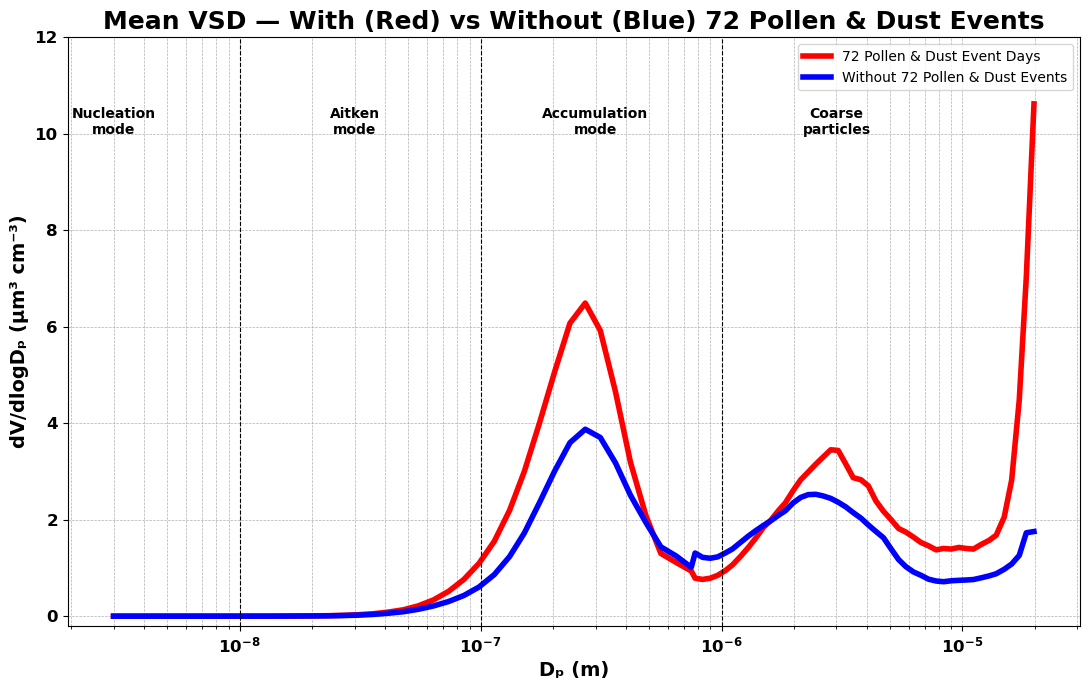

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths ===
file_no_events = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust events.xlsx'
file_events    = '/Users/touqeergill/Desktop/10. 72 Pollen and dust events.xlsx'

# === Load ===
df_no = pd.read_excel(file_no_events)
df_ev = pd.read_excel(file_events)

# Ensure datetime is parsed (not used further, but keeps parity with your originals)
df_no['datetime'] = pd.to_datetime(df_no['datetime'])
df_ev['datetime'] = pd.to_datetime(df_ev['datetime'])

# === Determine common diameter bins (exclude 'datetime' column) ===
cols_no = df_no.columns[1:]
cols_ev = df_ev.columns[1:]
common_cols = [c for c in cols_no if c in set(cols_ev)]

if len(common_cols) == 0:
    raise ValueError("No common diameter columns found between the two files.")

# Convert column labels to numeric diameters (meters) and to micrometers
# (Keep the plotting order as in the data by using common_cols sequence)
diameters_m = np.array([float(c) for c in common_cols], dtype=float)
diameters_um = diameters_m * 1e6

# === Convert number to volume distribution ===
# Volume factor (µm³) per particle in a bin: (π/6) * Dp^3, with Dp in µm
volume_factors = (np.pi / 6.0) * (diameters_um ** 3)  # µm³

# Multiply each bin column by the corresponding volume factor
vol_no = df_no[common_cols].astype(float) * volume_factors
vol_ev = df_ev[common_cols].astype(float) * volume_factors

# === Mean volume distributions across time (per bin) ===
mean_no = vol_no.mean(numeric_only=True)
mean_ev = vol_ev.mean(numeric_only=True)

# === Plot ===
plt.figure(figsize=(11, 7))
plt.plot(diameters_m, mean_ev.values, color='red',  linewidth=4, label='72 Pollen & Dust Event Days')
plt.plot(diameters_m, mean_no.values, color='blue', linewidth=4, label='Without 72 Pollen & Dust Events')

# Axes and labels
plt.xscale('log')
plt.ylim(-0.2, 12)
plt.xlabel('Dₚ (m)', fontsize=14, fontweight='bold')
plt.ylabel('dV/dlogDₚ (µm³ cm⁻³)', fontsize=14, fontweight='bold')
plt.title('Mean VSD — With (Red) vs Without (Blue) 72 Pollen & Dust Events', fontsize=18, fontweight='bold')

# Vertical reference lines for modes
plt.axvline(1e-8, color='k', linestyle='--', linewidth=0.8)
plt.axvline(1e-7, color='k', linestyle='--', linewidth=0.8)
plt.axvline(1e-6, color='k', linestyle='--', linewidth=0.8)

# Annotate particle modes (placed near top of y-axis)
y_label_pos = 10
plt.text(3e-9, y_label_pos, 'Nucleation\nmode',   fontsize=10, ha='center', fontweight='bold')
plt.text(3e-8, y_label_pos, 'Aitken\nmode',       fontsize=10, ha='center', fontweight='bold')
plt.text(3e-7, y_label_pos, 'Accumulation\nmode', fontsize=10, ha='center', fontweight='bold')
plt.text(3e-6, y_label_pos, 'Coarse\nparticles',  fontsize=10, ha='center', fontweight='bold')

# Final touches
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Bold tick labels
plt.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()

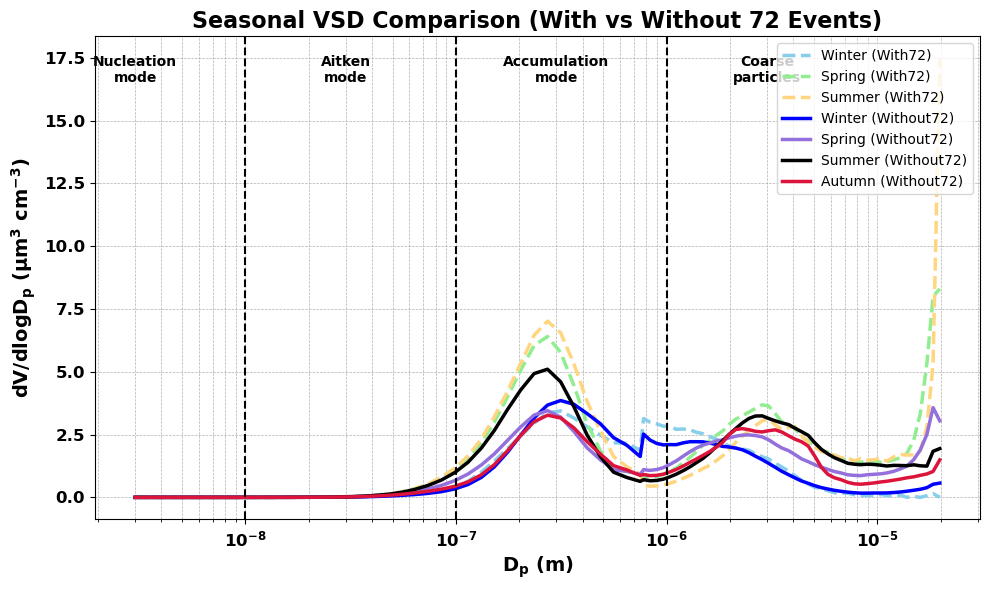

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths === #
with72_file_1 = '/Users/touqeergill/Desktop/10. 72 Pollen and dust events.xlsx'
without72_file_1 = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust events.xlsx'

# === Helper function to process seasonal data === #
def process_event_data(file_path):
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'

    df['Season'] = df['datetime'].dt.month.apply(get_season)
    diameter_cols = df.columns[1:-1]
    diameters_m = np.array([float(col) for col in diameter_cols])
    diameters_um = diameters_m * 1e6
    volume_factors = (np.pi / 6) * diameters_um**3
    volume_df = df[diameter_cols] * volume_factors
    volume_df['Season'] = df['Season']
    seasonal_means = volume_df.groupby('Season').mean()
    return diameters_m, seasonal_means

# === Load and process datasets === #
diameters_m_with72, seasonal_means_with72 = process_event_data(with72_file_1)
diameters_m_without72, seasonal_means_without72 = process_event_data(without72_file_1)

# === Colors === #
season_colors_with = {
    'Winter': '#87CEEB',  # Sky Blue
    'Spring': '#90EE90',  # Light Green
    'Summer': '#FFD580',  # Light Orange
    'Autumn': '#FFB6C1'   # Light Pink
}

dark_season_colors_without = {
    'Winter': '#0000FF',  # Blue
    'Spring': '#9370DB',  # Medium Purple
    'Summer': '#000000',  # Black
    'Autumn': '#DC143C'   # Crimson Red
}

# === Horizontal VSD Plot === #
fig, ax = plt.subplots(figsize=(10, 6))

# Plot With72 (dashed lines)
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means_with72.index:
        ax.plot(diameters_m_with72, seasonal_means_with72.loc[season],
                label=f'{season} (With72)', color=season_colors_with[season],
                linestyle='--', linewidth=2.5)

# Plot Without72 (solid lines)
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means_without72.index:
        ax.plot(diameters_m_without72, seasonal_means_without72.loc[season],
                label=f'{season} (Without72)', color=dark_season_colors_without[season],
                linestyle='-', linewidth=2.5)

# === Axis and Grid === #
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=14, fontweight='bold')
ax.set_ylabel(r'$\mathbf{dV/dlogD_p\ (µm^3\ cm^{-3})}$', fontsize=14, fontweight='bold')
ax.set_title('Seasonal VSD Comparison (With vs Without 72 Events)', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Bold tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(12)
    label.set_fontweight('bold')

# === Mode boundaries (vertical dashed lines) === #
for boundary in [1e-8, 1e-7, 1e-6]:
    ax.axvline(x=boundary, color='black', linestyle='--')

# === Mode Labels Inside Plot === #
y_max = ax.get_ylim()[1]
label_y = y_max * 0.90  # 95% of max y-value, inside the plot

ax.text(3e-9, label_y, 'Nucleation\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-8, label_y, 'Aitken\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-7, label_y, 'Accumulation\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-6, label_y, 'Coarse\nparticles', fontsize=10, fontweight='bold', ha='center')

# === Legend inside plot === #
ax.legend(loc='upper right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

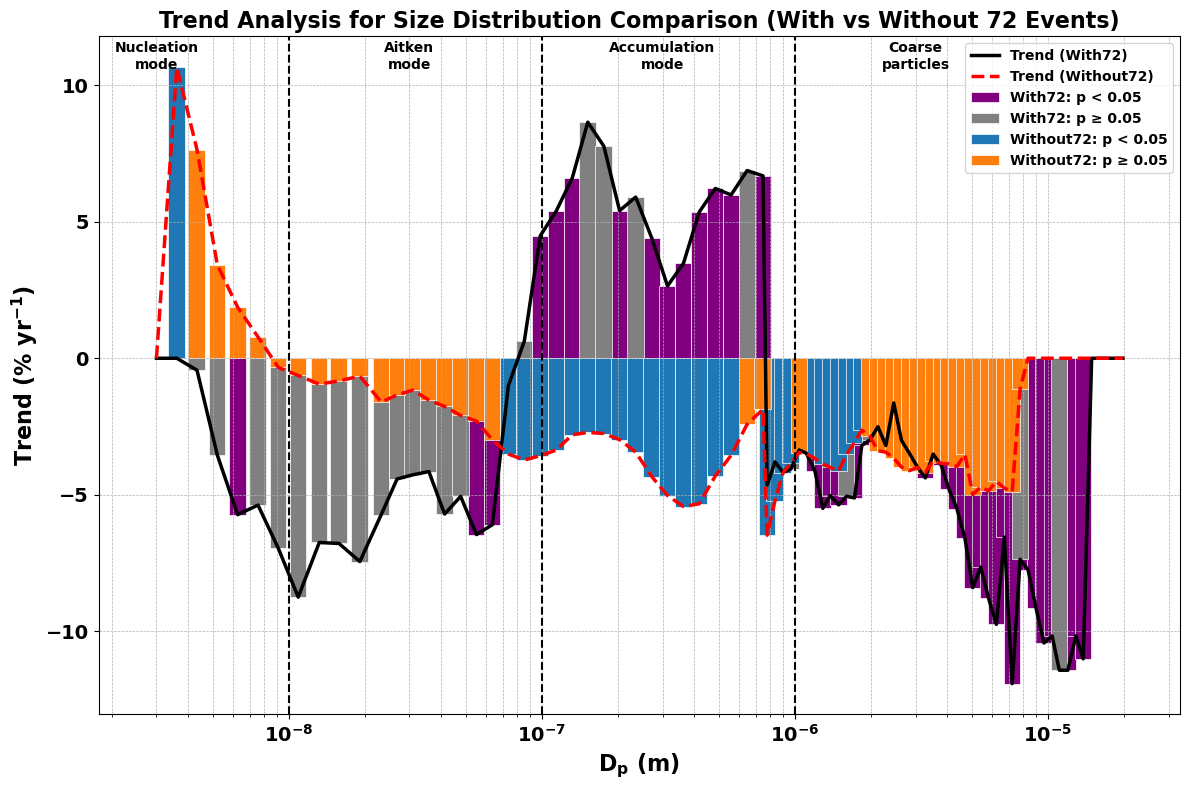

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths for trend data === #
with72_file_2 = '/Users/touqeergill/Desktop/10. 72 Pollen and dust Volume_dV_dlogDp.xlsx'
without72_file_2 = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust Volume_dV_dlogDp.xlsx'

# === Load trend data === #
df_with72_trend = pd.read_excel(with72_file_2)
df_without72_trend = pd.read_excel(without72_file_2)

# === Extract relevant data === #
particle_sizes = df_with72_trend['Bin'].astype(float).to_numpy()

trends_with72 = df_with72_trend['Relative Trend (%/yr)'].to_numpy()
p_with72 = df_with72_trend['p-value'].to_numpy()
sig_with72 = p_with72 < 0.05
nonsig_with72 = ~sig_with72

trends_without72 = df_without72_trend['Relative Trend (%/yr)'].to_numpy()
p_without72 = df_without72_trend['p-value'].to_numpy()
sig_without72 = p_without72 < 0.05
nonsig_without72 = ~sig_without72

# === Colors === #
pval_colors = {
    'with_sig': '#800080',       # Purple for With72: p < 0.05
    'with_nonsig': '#808080',    # Grey for With72: p ≥ 0.05
    'without_sig': '#1f77b4',    # Blue for Without72: p < 0.05
    'without_nonsig': '#ff7f0e'  # Orange for Without72: p ≥ 0.05
}

# === Plot Trend Analysis with Dp on X-Axis === #
fig, ax = plt.subplots(figsize=(12, 8))

# Plot trend lines
ax.plot(particle_sizes, trends_with72, color='black', linewidth=2.5, label='Trend (With72)')
ax.plot(particle_sizes, trends_without72, color='red', linestyle='--', linewidth=2.5, label='Trend (Without72)')

# Plot bars by significance
bar_width = particle_sizes * 0.15

ax.bar(particle_sizes[sig_with72], trends_with72[sig_with72],
       width=bar_width[sig_with72], color=pval_colors['with_sig'],
       edgecolor='white', linewidth=0.5, label='With72: p < 0.05')

ax.bar(particle_sizes[nonsig_with72], trends_with72[nonsig_with72],
       width=bar_width[nonsig_with72], color=pval_colors['with_nonsig'],
       edgecolor='white', linewidth=0.5, label='With72: p ≥ 0.05')

ax.bar(particle_sizes[sig_without72], trends_without72[sig_without72],
       width=bar_width[sig_without72], color=pval_colors['without_sig'],
       edgecolor='white', linewidth=0.5, label='Without72: p < 0.05')

ax.bar(particle_sizes[nonsig_without72], trends_without72[nonsig_without72],
       width=bar_width[nonsig_without72], color=pval_colors['without_nonsig'],
       edgecolor='white', linewidth=0.5, label='Without72: p ≥ 0.05')

# === Mode boundaries (vertical dashed lines) === #
for boundary in [1e-8, 1e-7, 1e-6]:
    ax.axvline(x=boundary, color='black', linestyle='--')

# === Axes formatting === #
ax.set_xscale('log')
ax.set_xlabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax.set_ylabel(r'$\mathbf{Trend\ (\%\ yr^{-1})}$', fontsize=16, fontweight='bold')
ax.set_title('Trend Analysis for Size Distribution Comparison (With vs Without 72 Events)', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# ✅ Legend inside plot (top-right)
ax.legend(fontsize=10, loc='upper right', prop={'weight': 'bold'})

# Tick formatting
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontweight('bold')

# === Mode Labels Inside Plot === #
y_max = ax.get_ylim()[1]
label_y = y_max * 0.90  # 95% of max y-value, inside the plot

ax.text(3e-9, label_y, 'Nucleation\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-8, label_y, 'Aitken\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-7, label_y, 'Accumulation\nmode', fontsize=10, fontweight='bold', ha='center')
ax.text(3e-6, label_y, 'Coarse\nparticles', fontsize=10, fontweight='bold', ha='center')

plt.tight_layout()
plt.show()

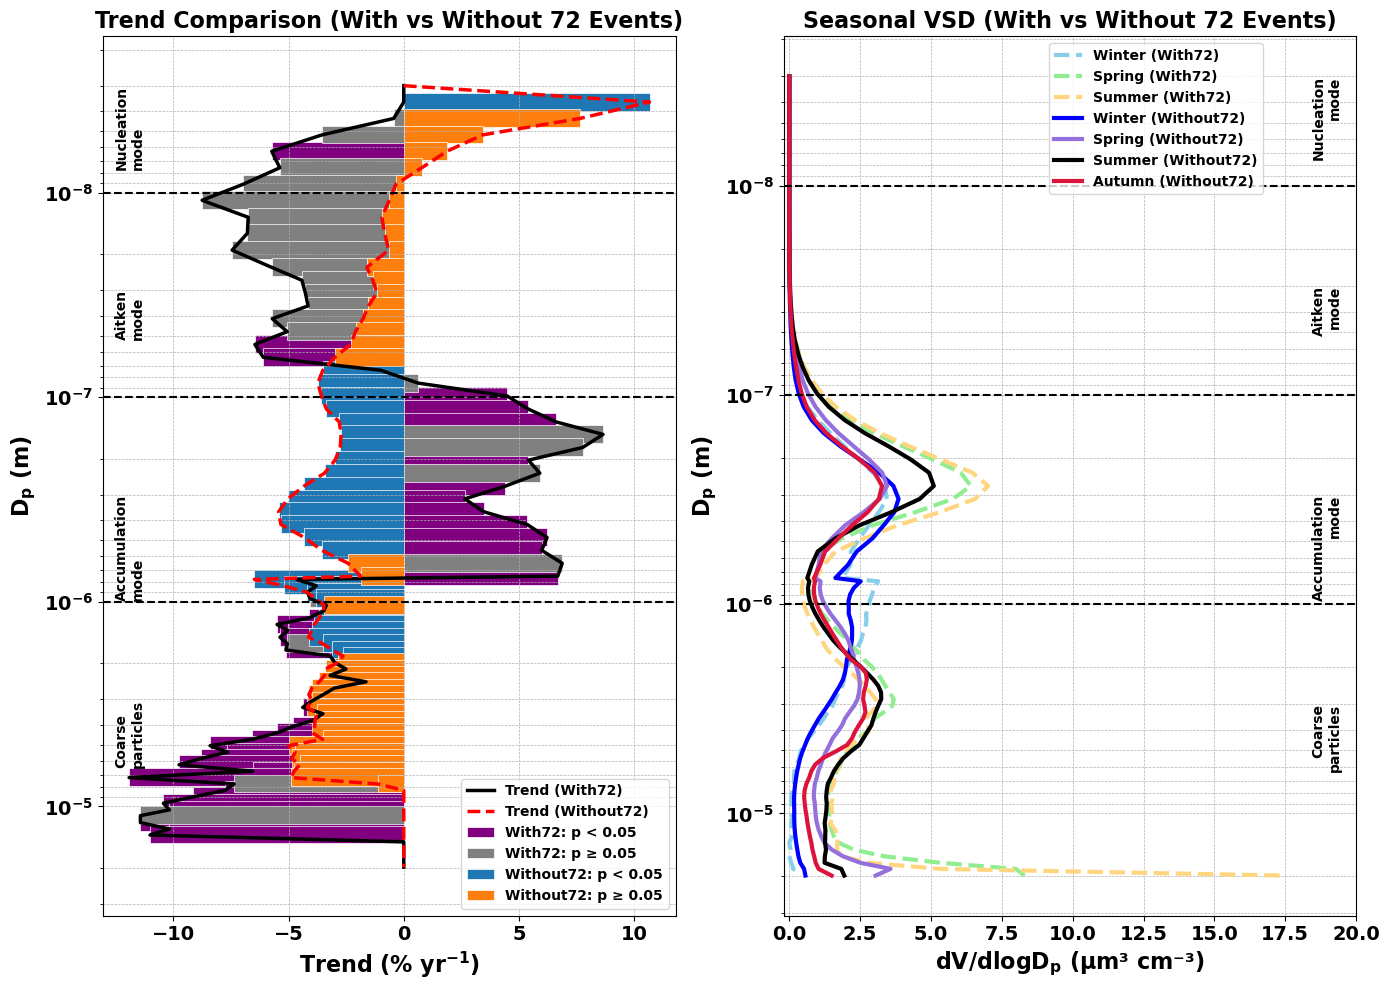

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === File paths === #
with72_file_1 = '/Users/touqeergill/Desktop/10. 72 Pollen and dust events.xlsx'
with72_file_2 = '/Users/touqeergill/Desktop/10. 72 Pollen and dust Volume_dV_dlogDp.xlsx'
without72_file_1 = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust events.xlsx'
without72_file_2 = '/Users/touqeergill/Desktop/10. Without 72 Pollen and dust Volume_dV_dlogDp.xlsx'

# === Helper function to process event data === #
def process_event_data(file_path):
    df = pd.read_excel(file_path)
    df['datetime'] = pd.to_datetime(df['datetime'])

    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Autumn'

    df['Season'] = df['datetime'].dt.month.apply(get_season)
    diameter_cols = df.columns[1:-1]
    diameters_m = np.array([float(col) for col in diameter_cols])
    diameters_um = diameters_m * 1e6
    volume_factors = (np.pi / 6) * diameters_um**3
    volume_df = df[diameter_cols] * volume_factors
    volume_df['Season'] = df['Season']
    seasonal_means = volume_df.groupby('Season').mean()

    return diameters_m, seasonal_means

# === Load and process datasets === #
diameters_m_with72, seasonal_means_with72 = process_event_data(with72_file_1)
diameters_m_without72, seasonal_means_without72 = process_event_data(without72_file_1)

df_with72_trend = pd.read_excel(with72_file_2)
df_without72_trend = pd.read_excel(without72_file_2)

# --- Extract trend data --- #
particle_sizes = df_with72_trend['Bin'].astype(float).to_numpy()

trends_with72 = df_with72_trend['Relative Trend (%/yr)'].to_numpy()
p_with72 = df_with72_trend['p-value'].to_numpy()
sig_with72 = p_with72 < 0.05
nonsig_with72 = ~sig_with72

trends_without72 = df_without72_trend['Relative Trend (%/yr)'].to_numpy()
p_without72 = df_without72_trend['p-value'].to_numpy()
sig_without72 = p_without72 < 0.05
nonsig_without72 = ~sig_without72

# === Define colors === #
season_colors_with = {
    'Winter': '#87CEEB',  # Sky Blue
    'Spring': '#90EE90',  # Light Green
    'Summer': '#FFD580',  # Light Orange
    'Autumn': '#FFB6C1'   # Light Pink
}

dark_season_colors_without = {
    'Winter': '#0000FF',  # Blue
    'Spring': '#9370DB',  # Medium Purple
    'Summer': '#000000',  # Black
    'Autumn': '#DC143C'   # Crimson Red
}

pval_colors = {
    'with_sig': '#800080',       # Purple for With72: p < 0.05
    'with_nonsig': '#808080',    # Grey for With72: p ≥ 0.05
    'without_sig': '#1f77b4',    # Blue for Without72: p < 0.05
    'without_nonsig': '#ff7f0e'  # Orange for Without72: p ≥ 0.05
}

# === Create the figure === #
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

# === Plot 1: Trend Analysis === #
ax1 = axs[0]
ax1.plot(trends_with72, particle_sizes, color='black', linewidth=2.5, label='Trend (With72)')
ax1.plot(trends_without72, particle_sizes, color='red', linestyle='--', linewidth=2.5, label='Trend (Without72)')

ax1.barh(particle_sizes[sig_with72], trends_with72[sig_with72],
         height=particle_sizes[sig_with72] * 0.2, color=pval_colors['with_sig'],
         edgecolor='white', linewidth=0.5, label='With72: p < 0.05')

ax1.barh(particle_sizes[nonsig_with72], trends_with72[nonsig_with72],
         height=particle_sizes[nonsig_with72] * 0.2, color=pval_colors['with_nonsig'],
         edgecolor='white', linewidth=0.5, label='With72: p ≥ 0.05')

ax1.barh(particle_sizes[sig_without72], trends_without72[sig_without72],
         height=particle_sizes[sig_without72] * 0.2, color=pval_colors['without_sig'],
         edgecolor='white', linewidth=0.5, label='Without72: p < 0.05')

ax1.barh(particle_sizes[nonsig_without72], trends_without72[nonsig_without72],
         height=particle_sizes[nonsig_without72] * 0.2, color=pval_colors['without_nonsig'],
         edgecolor='white', linewidth=0.5, label='Without72: p ≥ 0.05')

for boundary in [1e-8, 1e-7, 1e-6]:
    ax1.axhline(y=boundary, color='black', linestyle='--')

ax1.set_yscale('log')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax1.set_xlabel(r'$\mathbf{Trend\ (\%\ yr^{-1})}$', fontsize=16)
ax1.set_title('Trend Comparison (With vs Without 72 Events)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=10, loc='lower right', prop={'weight': 'bold'})
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.tick_params(axis='both')
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontweight('bold')

# === Plot 2: Seasonal VSD === #
ax2 = axs[1]

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means_with72.index:
        ax2.plot(seasonal_means_with72.loc[season], diameters_m_with72,
                 label=f'{season} (With72)', color=season_colors_with[season],
                 linestyle='--', linewidth=3)

for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    if season in seasonal_means_without72.index:
        ax2.plot(seasonal_means_without72.loc[season], diameters_m_without72,
                 label=f'{season} (Without72)', color=dark_season_colors_without[season],
                 linestyle='-', linewidth=3)

ax2.set_xlim(-0.2, 20)
ax2.set_yscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_ylabel(r'$\mathbf{D}_{\mathbf{p}}$ (m)', fontsize=16, fontweight='bold')
ax2.set_xlabel(r'dV/dlog$\mathbf{D}_{\mathbf{p}}$ (µm³ cm⁻³)', fontsize=16, fontweight='bold')
ax2.set_title('Seasonal VSD (With vs Without 72 Events)', fontsize=16, fontweight='bold')

for boundary in [1e-8, 1e-7, 1e-6]:
    ax2.axhline(y=boundary, color='black', linestyle='--')

ax2.legend(fontsize=10, loc='upper right', bbox_to_anchor=(0.85, 1.0), prop={'weight': 'bold'})
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.tick_params(axis='both')
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontsize(14)
    label.set_fontweight('bold')

# === Mode Labels === #
label_x_trend = ax1.get_xlim()[0] + 0.5
ax1.text(label_x_trend, 3e-9, 'Nucleation\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_trend, 3e-8, 'Aitken\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_trend, 3e-7, 'Accumulation\nmode', fontsize=10, fontweight='bold', va='top', rotation=90)
ax1.text(label_x_trend, 3e-6, 'Coarse\nparticles', fontsize=10, fontweight='bold', va='top', rotation=90)

label_x_volume = ax2.get_xlim()[1] - 0.5
ax2.text(label_x_volume, 3e-9, 'Nucleation\nmode', fontsize=10, fontweight='bold', va='top', ha='right', rotation=90)
ax2.text(label_x_volume, 3e-8, 'Aitken\nmode', fontsize=10, fontweight='bold', va='top', ha='right', rotation=90)
ax2.text(label_x_volume, 3e-7, 'Accumulation\nmode', fontsize=10, fontweight='bold', va='top', ha='right', rotation=90)
ax2.text(label_x_volume, 3e-6, 'Coarse\nparticles', fontsize=10, fontweight='bold', va='top', ha='right', rotation=90)

# === Final Layout === #
plt.tight_layout()
plt.show()